In [ ]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata 
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
import collections
from natsort import natsorted

from scipy import stats
from scipy import sparse
from sklearn.decomposition import PCA
from umap import UMAP

from matplotlib.colors import LinearSegmentedColormap

from scroutines.config_plots import *
from scroutines import powerplots # .config_plots import *
from scroutines import pnmf
from scroutines import basicu


In [ ]:
outdir_fig = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/figures"

# load gene annotation and data

In [ ]:
annots = {}

f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/annot/Mus_musculus_TF.txt'
annot = pd.read_csv(f, sep='\t')
annots['tf'] = annot['Symbol'].values

f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/annot/genes_cadherins.txt'
annot = pd.read_csv(f, sep='\t')
annots['cad'] = annot['Approved symbol'].apply(lambda x: x[0]+x[1:].lower()).values

f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/annot/genes_igsf.txt'
annot = pd.read_csv(f, sep='\t')
annots['igsf'] = annot['Approved symbol'].apply(lambda x: x[0]+x[1:].lower()).values

f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/annot/genes_ephephrins.txt'
annot = pd.read_csv(f, sep='\t')
annots['eph'] = annot['Approved symbol'].apply(lambda x: x[0]+x[1:].lower()).values

f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/annot/genes_semaphorins.txt'
annot = pd.read_csv(f, sep='\t')
annots['sema'] = annot['Approved symbol'].apply(lambda x: x[0]+x[1:].lower()).values

f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/annot/genes_teneurins.txt'
annot = pd.read_csv(f, sep='\t')
annots['tene'] = annot['Approved symbol'].apply(lambda x: x[0]+x[1:].lower()).values

f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/annot/genes_gpcr.txt'
annot = pd.read_csv(f, sep='\t')
annots['gpcr'] = annot['Approved symbol'].apply(lambda x: x[0]+x[1:].lower()).values

f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/annot/genes_ion_channels.txt'
annot = pd.read_csv(f, sep='\t')
annots['channel'] = annot['Approved symbol'].apply(lambda x: x[0]+x[1:].lower()).values

annots['astn'] = np.array(['Astn1', 'Astn2']) # astrotactin
annots['caps'] = np.array(['Cadps1', 'Cadps2']) # # synapse related caps calcium-dependent activator of secretion (CAPS) protein family
list(annots.keys())

In [ ]:
# AC genes
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/Saumya_P6-21_AC_genes.csv'
df = pd.read_csv(f)

df_a = df.iloc[:25]
df_c = df.iloc[25:]

alltime_a = np.unique(df_a.values)
alltime_c = np.unique(df_c.values)
alltime_ac = np.hstack([alltime_a, alltime_c])

ac_overlap = np.intersect1d(alltime_a, alltime_c)

print(df_a.shape, df_c.shape, alltime_a.shape, alltime_c.shape, alltime_ac.shape, ac_overlap.shape)
df.head()

In [ ]:
# use those 286 genes
# df = pd.read_csv("../../data/cheng21_cell_scrna/res/candidate_genes_vincent_0503_v2.csv")
df = pd.read_csv("../../data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot.csv")
genes_l23 = df['gene'].astype(str).values
genes_l23a = df[df['P17on']=='A']['gene'].astype(str).values
genes_l23b = df[df['P17on']=='B']['gene'].astype(str).values
genes_l23c = df[df['P17on']=='C']['gene'].astype(str).values

print(genes_l23a.shape, genes_l23b.shape, genes_l23c.shape)
genes_grp = df['P17on'].astype(str).values
assert len(genes_l23) == len(np.unique(genes_l23))

genes_l23.shape

In [ ]:
adata = anndata.read("../../data/v1_multiome/L23_allmultiome_raw.h5ad")
adata

In [ ]:
sample_labels = ["-".join(cell.split(' ')[0].split('-')[2:]).replace('-2023', '') for cell in adata.obs.index]
time_labels = [s[:-1].replace('DR', '') for s in sample_labels]

adata.obs['n_counts'] = adata.obs['nCount_RNA']
adata.obs['sample'] = sample_labels
adata.obs['time']   = time_labels

uniq_samples = natsorted(np.unique(sample_labels))
uniq_times = natsorted(np.unique(time_labels))

nr_samples = [s for s in uniq_samples if "DR" not in s]
dr_samples = [s for s in uniq_samples if "DR" in s]
print(uniq_times)
print(nr_samples)
print(dr_samples)

# adata.obs['sample'] = sample_labels

In [ ]:
# select samples
adata = adata[adata.obs['sample'].isin(nr_samples)]
adata = adata[adata.obs['time'].isin(['P6', 'P8', 'P10', 'P12', 'P14', 'P17', 'P21'])]
adata.obs['cond'] = adata.obs['time']

# remove mitocondria genes
adata = adata[:,~adata.var['features'].str.contains(r'^mt-')]

# select
# adata = adata[adata.obs['cond'].str.contains(r"NR$")]
adata.obs['sample'].unique(), adata.obs['cond'].unique()

In [ ]:
# define
# genes = adata.var.index.values
conds = adata.obs['cond'].values
types = adata.obs['Type'].values
samps = adata.obs['sample'].values

# organize
rename = {
    "L2/3_A": "L2/3_A",
    "L2/3_B": "L2/3_B",
    "L2/3_C": "L2/3_C",
    
    "L2/3_1": "L2/3_A",
    "L2/3_2": "L2/3_B",
    "L2/3_3": "L2/3_C",
    
    "L2/3_AB": "L2/3_A",
    "L2/3_BC": "L2/3_C",
}
adata.obs['easitype'] = adata.obs['Type'] #.apply(lambda x: rename[x])
adata

In [ ]:
adata.obs['Type'].unique()

In [ ]:
# filter genes
cond = np.ravel((adata.X>0).sum(axis=0)) > 10 # expressed in more than 10 cells
adata = adata[:,cond].copy()
genes = adata.var.index.values

# counts
x = adata.X
cov = adata.obs['n_counts'].values
genes = adata.var.index.values

# CP10k
# xn = x/cov.reshape(x.shape[0], -1)*1e4
xn = (sparse.diags(1/cov).dot(x))*1e4

# log10(CP10k+1)
xln = xn.copy()
xln.data = np.log10(xln.data+1)

adata.layers[    'norm'] = np.array(xn.todense())
adata.layers[ 'lognorm'] = np.array(xln.todense())
adata.layers['zlognorm'] = zscore(np.array(xln.todense()), axis=0)

In [ ]:
# select HVGs with mean and var
nbin = 20
qth = 0.3

# min
gm = np.ravel(xn.mean(axis=0))

# var
tmp = xn.copy()
tmp.data = np.power(tmp.data, 2)
gv = np.ravel(tmp.mean(axis=0))-gm**2

# cut 
lbl = pd.qcut(gm, nbin, labels=np.arange(nbin))
gres = pd.DataFrame()
gres['name'] = genes
gres['lbl'] = lbl
gres['mean'] = gm
gres['var'] = gv
gres['ratio']= gv/gm

# select
gres_sel = gres.groupby('lbl')['ratio'].nlargest(int(qth*(len(gm)/nbin))) #.reset_index()
gsel_idx = np.sort(gres_sel.index.get_level_values(1).values)
assert np.all(gsel_idx != -1)


In [ ]:
# gsel_idx = np.union1d(gsel_idx, gaba_idx)

# # 
l23_gidx = basicu.get_index_from_array(genes, genes_l23)
l23_gidx = l23_gidx[l23_gidx!=-1]
assert np.all(l23_gidx != -1)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(6*2,4), sharex=True, sharey=True)
ax = axs[0]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.set_title(f'{len(gm):,} genes')

ax = axs[1]
ax.scatter(gm, gv/gm, s=5, edgecolor='none', color='gray')
ax.scatter(gm[gsel_idx], (gv/gm)[gsel_idx], c=lbl[gsel_idx], s=5, edgecolor='none', cmap='viridis_r', label=f'{len(gsel_idx):,} HVGs')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('mean expr (CP10k)')
ax.set_ylabel('var/mean')
ax.legend(bbox_to_anchor=(1,1))

plt.show()

In [ ]:
adata_sub = adata[:,l23_gidx]
adata_subp8 = adata_sub[adata_sub.obs['cond'].isin(['P8'])]
adata_subp17on = adata_sub[adata_sub.obs['cond'].isin(['P17', 'P21', 'P28'])]
genes_sel = adata_sub.var.index.values


pca = PCA(n_components=5)
pca.fit(adata_subp8.layers['lognorm'][...])
pcs_p8 = pca.transform(adata_sub.layers['lognorm'][...])
pcs_p8[:,0] = -pcs_p8[:,0] # flip PC1
pcs_p8[:,2] = -pcs_p8[:,2] # flip PC3


pca2 = PCA(n_components=5)
pca2.fit(adata_subp17on.layers['zlognorm'][...])
pcs_p17on = pca2.transform(adata_sub.layers['zlognorm'][...])
pcs_p17on[:,1] = -pcs_p17on[:,1] # flip PC2

In [ ]:
vt = pca.components_
topgenes_p8_pc1 = genes_sel[np.argsort(np.abs(vt[0]))[::-1]]
print(topgenes_p8_pc1[:10])
topgenes_p8_pc2 = genes_sel[np.argsort(np.abs(vt[1]))[::-1]]
print(topgenes_p8_pc2[:10])
topgenes_p8_pc3 = genes_sel[np.argsort(np.abs(vt[2]))[::-1]]
print(topgenes_p8_pc3[:10])

In [ ]:
adata.obsm['pca_p17on'] = pcs_p17on
adata.obsm['pca_p8'] = pcs_p8

In [ ]:
res0 = pd.DataFrame(adata.layers['zlognorm'][...], columns=genes)
res0['cond'] = conds
res0['type'] = types
res0['samp'] = samps
res0['rep']  = [samp[-1] for samp in samps]
res0['type'] = np.char.add('c', res0['type'].values.astype(str))

res1 = pd.DataFrame(pcs_p8, columns=np.char.add("p8PC", ((1+np.arange(pcs_p8.shape[1])).astype(str))))
res2 = pd.DataFrame(pcs_p17on, columns=np.char.add("p17onPC", ((1+np.arange(pcs_p17on.shape[1])).astype(str))))
res = pd.concat([res0, res1, res2], axis=1)

In [ ]:
allcolors = sns.color_palette('tab20c', 20)
allcolors

In [ ]:
allcolors2 = sns.color_palette('tab10', 20)
allcolors2

In [ ]:
palette = collections.OrderedDict({
     "P6": allcolors[2],
     "P8": allcolors[1],
    "P10": allcolors[0],
    "P12": allcolors[4+2],
    "P14": allcolors[4+0],
    
    "P17": allcolors[8+2],
    "P21": allcolors[8+0],
    
})
cases = np.array(list(palette.keys()))

cond_order_dict = {
    'P6':  0,
    'P8':  1,
    'P10': 2,
    'P12': 3,
    'P14': 4,
    'P17': 5,
    'P21': 6,
}
unq_conds = np.array(list(cond_order_dict.keys()))
adata.obs['cond_order'] = adata.obs['cond'].apply(lambda x: cond_order_dict[x])

palette_types = collections.OrderedDict({
    'L2/3_A': allcolors2[0],
    'L2/3_B': allcolors2[1],
    'L2/3_C': allcolors2[2],
})             

palette_types = {
    'c14': 'C0', 
    'c18': 'C1',
    'c16': 'C2', 
    
    'c13': 'C0', 
    'c15': 'C1', 
    'c17': 'C2',
}
type_order = [key for key, val in palette_types.items()]
type_order

In [ ]:
from scipy import stats
from matplotlib.ticker import MaxNLocator

def plot(x, y, aspect_equal=False, density=False, hue='type'):
    n = 7
    fig, axs = plt.subplots(1,n,figsize=(4*n,4*1), sharex=True, sharey=True)
    for i, (ax, cond) in enumerate(zip(axs.flat, cases)):
        ax.set_title(cond)
        sns.scatterplot(data=res, 
                        x=x, y=y, 
                        c='lightgray',
                        s=1, edgecolor='none', 
                        legend=False,
                        ax=ax,
                       )
        if hue == 'type':
            sns.scatterplot(data=res[res['cond']==cond].sample(frac=1, replace=False),
                            x=x, y=y, 
                            hue='type',
                            hue_order=list(palette_types.keys()),
                            palette=palette_types,
                            s=3, edgecolor='none', 
                            legend=False,
                            ax=ax,
                           )
        else:
            sns.scatterplot(data=res[res['cond']==cond].sample(frac=1, replace=False),
                            x=x, y=y, 
                            hue='rep',
                            # hue_order=list(palette_types.keys()),
                            # palette=palette_types,
                            s=3, edgecolor='none', 
                            legend=False,
                            ax=ax,
                           )
            
        if density:
            sns.histplot(data=res[res['cond']==cond],
                            x=x, y=y, 
                            legend=False,
                            ax=ax,
                           )
        sns.despine(ax=ax)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
        if aspect_equal:
            ax.set_aspect('equal')
        if i > 0:
            ax.set_xlabel('')
            ax.set_ylabel('')
    plt.show()
    
def plot2(x, y, hue=None, aspect_equal=False):
    n = 7
    fig, axs = plt.subplots(1,n,figsize=(4*n,4*1), sharex=True, sharey=True)
    fig.suptitle(hue, x=0, ha='left')
    for i, (ax, cond) in enumerate(zip(axs.flat, cases)):
        ax.set_title(cond)
        sns.scatterplot(data=res, 
                        x=x, y=y, 
                        c='lightgray',
                        alpha=0.3,
                        s=1, edgecolor='none', 
                        legend=False,
                        ax=ax,
                       )
        show = res[res['cond']==cond]
        if hue:
            ax.scatter(show[x], show[y], c=show[hue], 
                       cmap='coolwarm',
                       vmin=-3, vmax=3,
                       s=5, 
                       edgecolor='none', 
                      )
        else:
            r, p = stats.spearmanr(show[x], show[y])
            ax.scatter(show[x], show[y],  
                       s=5, 
                       edgecolor='none', 
                      )
            ax.set_title(f'{cond}\n r={r:.2f}')
        sns.despine(ax=ax)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
        if aspect_equal:
            ax.set_aspect('equal')
        if i > 0:
            ax.set_xlabel('')
            ax.set_ylabel('')
        ax.grid(False)
    fig.tight_layout()
    plt.show()

# Plot A vs C genes aligning cells along early vs late PCs

In [ ]:
plot('p17onPC1', 'p17onPC2', aspect_equal=True)
plot('p8PC1', 'p8PC2', aspect_equal=True)

# get top 20% A vs C in each case

In [ ]:
from statsmodels.stats.multitest import multipletests

In [ ]:
qs_avc = []
l2fc_avc = []

for cond_order, obssub in adata.obs.groupby('cond_order'):
    # get sub
    adatasub = adata[obssub.index]
    
    # get A vs C 
    x = adatasub.obsm['pca_p17on'][...,0]
    cond_a = x < np.percentile(x,20)
    cond_c = x > np.percentile(x,80)
    adatasub_a = adatasub[cond_a]
    adatasub_c = adatasub[cond_c]
    
    # DEGs
    mat_a = adatasub_a.layers['lognorm'][...]
    mat_c = adatasub_c.layers['lognorm'][...]
    ts, ps = stats.ttest_ind(mat_a, mat_c)
    rs, qs, _, _ = multipletests(np.nan_to_num(ps, nan=1).reshape(-1,), method='fdr_bh') # why nan in ps -- not expressed
    lfc = np.log2(10)*(np.mean(mat_c, axis=0) - np.mean(mat_a, axis=0)) # log2FC (log10CPM as raw counts)
    
    num_sig = np.sum(np.logical_and(qs < 0.05, np.abs(lfc) > 1))
    print(cond_order, adatasub_a.shape, num_sig)
    
    # save this
    qs_avc.append(qs)
    l2fc_avc.append(lfc)
    
qs_avc = np.array(qs_avc)
l2fc_avc = np.array(l2fc_avc)

In [ ]:
adata.uns['qs_avc'] = qs_avc
adata.uns['l2fc_avc'] = l2fc_avc
adata

In [ ]:
l2fc_th = 1
alpha_th = 0.05
cond_sig   = np.logical_and(qs_avc < alpha_th, np.abs(l2fc_avc) > l2fc_th)
cond_sig_c = np.logical_and(qs_avc < alpha_th, l2fc_avc >  l2fc_th)
cond_sig_a = np.logical_and(qs_avc < alpha_th, l2fc_avc < -l2fc_th)

print('num AvsC-DEGs per cond:\t', cond_sig.sum(axis=1))
print('num A-DEGs per cond:\t',    cond_sig_a.sum(axis=1))
print('num C-DEGs per cond:\t',    cond_sig_c.sum(axis=1))

In [ ]:
gene_sig_instances   = cond_sig.sum(axis=0)
gene_sig_instances_a = cond_sig_a.sum(axis=0)
gene_sig_instances_c = cond_sig_c.sum(axis=0)

instances, counts = np.unique(gene_sig_instances, return_counts=True)
instances_a, counts_a = np.unique(gene_sig_instances_a, return_counts=True)
instances_c, counts_c = np.unique(gene_sig_instances_c, return_counts=True)

print('num AvsC-DEGs in num conds:\t',  counts  , np.any(cond_sig, axis=0).sum())
print('num A-DEGs in num conds:\t',     counts_a, np.any(cond_sig_a, axis=0).sum())
print('num C-DEGs in num conds:\t',     counts_c, np.any(cond_sig_c, axis=0).sum())

In [ ]:
a_any = np.sort(adata.var[np.any(cond_sig_a, axis=0)].index.values)
c_any = np.sort(adata.var[np.any(cond_sig_c, axis=0)].index.values)
a_all = np.sort(adata.var[np.all(cond_sig_a, axis=0)].index.values)
c_all = np.sort(adata.var[np.all(cond_sig_c, axis=0)].index.values)
ac_overlap = np.sort(adata.var[np.logical_and(np.any(cond_sig_a, axis=0), np.any(cond_sig_c, axis=0))].index.values)

print('a any', a_any)
print('c any', c_any)
print('a all', a_all)
print('c all', c_all)
print('ac overlap', ac_overlap)

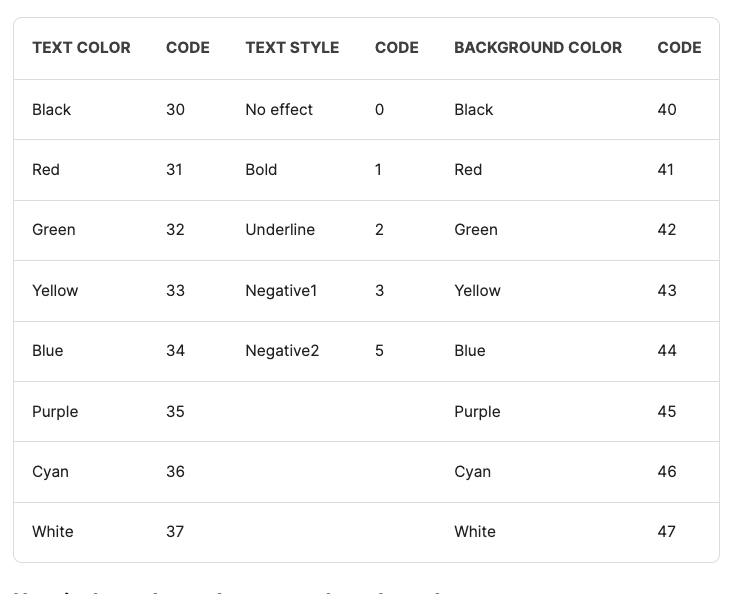

In [ ]:
annots_colors = {
    'tf':      '34', # blue
    
    'igsf':    '31', # red - adhesion and wiring
    'cad':     '31',
    'eph':     '31',
    'sema':    '31',
    'tene':    '31',
    'astn':    '31',
    
    'channel': '33', # yellow - receptor, channel, synapse
    'gpcr':    '33',
    'caps':    '33',
}

# annots_colors = {
#     'tf':      '44', # blue
    
#     'igsf':    '41', # red
#     'eph':     '41',
#     'cad':     '41',
    
#     'channel': '43', # yellow
#     'gpcr':    '43',
# }

In [ ]:
def check_genes(query, annots=annots, annots_colors=annots_colors):
    """
    """
    query_colors = [""]*len(query)
    query_annots = [""]*len(query)
    
    for i, q in enumerate(query):
        # default
        qa = "-"*len(q)
        query_annots[i] = qa  
        query_colors[i] = "30"
        
        # update if agree
        for key, glists in annots.items():
            if q in glists:
                query_annots[i] = key
                query_colors[i] = annots_colors[key]
    
    query_styled = [f"\033[0;{b}m{a}" for a, b in zip(query, query_colors)]
    query_annots_styled = [f"\033[0;{b}m{a}" for a, b in zip(query_annots, query_colors)]
    
    return query_annots, query_styled, query_annots_styled

In [ ]:
a_all_annots, a_all_styled, a_all_annots_styled = check_genes(a_all)
c_all_annots, c_all_styled, c_all_annots_styled = check_genes(c_all)

print("\t".join(a_all))
print("\t".join(a_all_annots_styled)) # _styled))

In [ ]:
print("\t".join(c_all))
print("\t".join(c_all_annots_styled)) # _styled))

In [ ]:
print("\033[0;m alltime A:", "\t".join(a_all_styled))
print("\033[0;m alltime C:", "\t".join(c_all_styled))

# Volcano

In [ ]:
def show_volcano_v2(thetypeidx, thetype, lfc, qs,
                    cond1, cond2up, cond2dn, 
                    querygenes_idx=None, 
                    gene_annots=None,
                    ax=None, bbox_to_anchor=(1,1), loc=None,
                   ): 
    """
    """
    eff = lfc[:,thetypeidx]
    pvl = -np.log10(qs[:,thetypeidx]) # +1e-10)
    cnd_up = np.all([cond1[:,thetypeidx], 
                     cond2up[:,thetypeidx]], axis=0) 
    cnd_dn = np.all([cond1[:,thetypeidx], 
                     cond2dn[:,thetypeidx]], axis=0) 

    if ax is None: 
        fig, ax = plt.subplots()
    
    # all genes
    ax.scatter(eff, pvl, s=1, color='lightgray', rasterized=True)

    # up genes
    ax.scatter(eff[cnd_up], pvl[cnd_up], s=3, facecolors='C0', rasterized=True)
    # dn genes
    ax.scatter(eff[cnd_dn], pvl[cnd_dn], s=3, facecolors='C1', rasterized=True)
    
    # # query genes
    # add text
    if querygenes_idx is not None:
        ax.scatter(eff[querygenes_idx], pvl[querygenes_idx], s=15, 
                   # label=f'type-specific (n={len(querygenes_idx):,})',
                   facecolors='none', edgecolors='k', linewidth=1, rasterized=True)
        for idx in querygenes_idx:
            ax.text(eff[idx], pvl[idx], gene_annots[idx], fontsize=10)

            
    # ax.grid(axis='y')
    sns.despine(ax=ax)
    ax.set_xlabel('log2(FC) (C/A in CP10k)')
    ax.set_ylabel('-log10(adj. p)')
    ax.set_title(f'{thetype}')
    ax.text(1,0.1,
            f'up (n={cnd_up.sum():,})\ndown (n={cnd_dn.sum():,})', 
            ha='right',
            fontsize=10, transform=ax.transAxes)
    return 

In [ ]:
unq_condidx = adata.obs['cond_order'].unique()
unq_condidx, unq_conds

In [ ]:
genes_comm = adata.var.index.values
lfc = adata.uns['l2fc_avc'].T
qs  = adata.uns['qs_avc'].T
lfc_th, qs_th = 1, 0.05

In [ ]:
cond1   = qs  <  qs_th
cond2up = lfc >  lfc_th
cond2dn = lfc < -lfc_th

In [ ]:
# typegenes_idx = basicu.get_index_from_array(genes_comm, df2.gene)

In [ ]:
thetypeidx = 0 # type A 
thetype = 'L2/3_A'
show_volcano_v2(thetypeidx, thetype, lfc, qs, cond1, cond2up, cond2dn) #  typegenes_idx)

In [ ]:
n = len(unq_conds)
fig, axs = plt.subplots(1,n,figsize=(4*n,4*1), sharex=True, sharey=True)
for cond_idx in unq_condidx:
    ax = axs.flat[cond_idx]
    thecond = unq_conds[cond_idx]
    show_volcano_v2(cond_idx, thecond, lfc, qs, cond1, cond2up, cond2dn, 
                    # typegenes_idx, 
                    ax=ax, bbox_to_anchor=(0.5, -0.3), loc='upper center')
    sns.despine(ax=ax)
fig.tight_layout()

# output = os.path.join(outfigdir, "volcano.pdf")
# powerplots.savefig_autodate(fig, output)
plt.show()

In [ ]:
querygenes = ['Meis2','Foxp1','Cdh13','Cdh12']
querygenes_idx = basicu.get_index_from_array(genes_comm, querygenes) 
gene_annots = genes_comm

n = len(unq_conds)
fig, axs = plt.subplots(2,4,figsize=(4*4,4*2), sharex=True, sharey=True)
for cond_idx in unq_condidx:
    ax = axs.flat[cond_idx]
    thecond = unq_conds[cond_idx]
    show_volcano_v2(cond_idx, thecond, lfc, qs, cond1, cond2up, cond2dn, 
                    querygenes_idx=querygenes_idx, 
                    gene_annots=genes_comm,
                    ax=ax, bbox_to_anchor=(0.5, -0.3), loc='upper center')
    sns.despine(ax=ax)
fig.tight_layout()
plt.show()

In [ ]:
# all tfs 
# not a meaningful test

In [ ]:
genes_sig = genes_comm[np.any(np.abs(lfc) > 1, axis=1)]
querygenes = np.intersect1d(annots['tf'], genes_sig) #['Meis2','Foxp1','Cdh13','Cdh12']
querygenes_idx = basicu.get_index_from_array(genes_comm, querygenes) 
gene_annots = genes_comm

n = len(unq_conds)
fig, axs = plt.subplots(2,4,figsize=(4*4,4*2), sharex=True, sharey=True)
for cond_idx in unq_condidx:
    ax = axs.flat[cond_idx]
    thecond = unq_conds[cond_idx]
    show_volcano_v2(cond_idx, thecond, lfc, qs, cond1, cond2up, cond2dn, 
                    querygenes_idx=querygenes_idx, 
                    gene_annots=genes_comm,
                    ax=ax, bbox_to_anchor=(0.5, -0.3), loc='upper center')
    sns.despine(ax=ax)
fig.tight_layout()
plt.show()

# show results old

In [ ]:
def show_onetype(idx, columns=["NR_1", "NR_2", "NR_3", "NR_4", 
                               "DR_1", "DR_2", "DR_3", "DR_4",
                              ]):
    """idx - cell type idx
    """
    gidx = np.logical_or(sde_up[:,idx], sde_dn[:,idx])
    _genes = genes_comm[gidx]

    p_nr = tensor_nr[gidx,:,:][:,idx,:]
    p_dr = tensor_dr[gidx,:,:][:,idx,:]
    
    
    ab = np.hstack([p_nr, p_dr])
    nr_mean = np.mean(p_nr, axis=1)
    ab = (ab - nr_mean.reshape(-1,1))*np.log2(10) # log2 FC w.r.t. the mean in NR
    ab = pd.DataFrame(ab, index=_genes, columns=columns)
    
    this_mlfc = (np.mean(p_nr, axis=1) - np.mean(p_dr, axis=1))*np.log2(10)
    this_ordr = np.argsort(this_mlfc)
    ab = ab.iloc[this_ordr]
    
    fig, ax = plt.subplots(figsize=(4, min(10, 0.3*len(ab))))
    sns.heatmap(ab, center=0, cmap='coolwarm', yticklabels=True, cbar_kws=dict(shrink=0.5, label='log2 FC (w.r.t. NR mean)'))
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(unq_types[idx])
    plt.show()

In [ ]:
def show_volcano(thetypeidx, thetype, lfc, qs, cond1, cond2up, cond2dn, ax=None, bbox_to_anchor=(1,1), loc=None):
    """
    Gene by type matrices: 
        lfc matrix: log fold change
        qs matirx:
    
        cond1 : significant or not? 
        cond2up: FC above the cutoff?
        cond2dn: FC below the cutoff?
    
    thetypeidx: pick a type - one column index from the above matrices
    """
    eff = lfc[:,thetypeidx]
    pvl =  qs[:,thetypeidx]

    cnd_up = np.all([cond1[:,thetypeidx], 
                     cond2up[:,thetypeidx]], axis=0) 
    cnd_dn = np.all([cond1[:,thetypeidx], 
                     cond2dn[:,thetypeidx]], axis=0) 

    if ax is None:
        fig, ax = plt.subplots()
    else:
        pass
    ax.scatter(eff, -np.log10(pvl), s=1, color='gray')

    ax.scatter(eff[cnd_up], -np.log10(pvl)[cnd_up], s=5, #s=5, 
               label=f'DR up (n={cnd_up.sum():,})')
    ax.scatter(eff[cnd_dn], -np.log10(pvl)[cnd_dn], s=5, #s=5, 
               label=f'DR dn (n={cnd_dn.sum():,})')

    ax.set_xlabel('log2(FC) (DR/NR in CPM)')
    ax.set_ylabel('-log10(FDR)')
    ax.set_title(f'{thetype}')
    ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc)
    return ax

In [ ]:
columns = [
    'NR_P28_1', '2', 'NR_P38_1', '2',
    'DR_P28_1', '2', 'DR_P38_1', '2',
]
with sns.plotting_context('paper'):
    for i, (_type, row) in enumerate(sigsum.iterrows()):
        if row['DE'] > 0:
            show_onetype(i, columns=columns)

# Check a few genes and see

In [ ]:
for gene_name in ['Cdh13', 'Trpc6', 'Chrm2']: #['Col19a1', 'Nr4a2', 'Fosb']:
    fig, axs = plt.subplots(1,3,figsize=(2*3,5), sharey=True)
    fig.suptitle(gene_name, y=1.1)
    for type_name, ax in zip(['L2/3_A', 'L2/3_B', 'L2/3_C'], axs):
        gidx = basicu.get_index_from_array(genes, [gene_name])[0]
        gidx2 = basicu.get_index_from_array(genes_comm, [gene_name])[0]
        cidx = basicu.get_index_from_array(unq_types, [type_name])[0]
        p_nr, p_dr = pbulks[:,:,:,gidx][:,:,cidx]
        assert gidx != -1
        assert cidx != -1

        sns.boxplot  ([p_nr, p_dr], color='white', ax=ax)
        sns.swarmplot([p_nr, p_dr], s=5, ax=ax)

        # check
        # l2fc2 = np.log2(10)*(np.mean(p_dr) - np.mean(p_nr))
        eff = lfc[gidx2, cidx]
        q   = qs[gidx2, cidx]
        sns.despine(ax=ax)

        ax.set_xticklabels(['NR', 'DR'])
        ax.set_ylabel('log10CPM')
        ax.set_title(f'{type_name}\n q={q:.1g}')
    plt.show()

# a plot of those unique genes across all cell types

In [ ]:
from scipy.stats import zscore

In [ ]:
degs = np.unique(res['gene'])
degs_idx = basicu.get_index_from_array(genes, degs)

row = degs
col = unq_types

In [ ]:
a = pbulks[:,:,:,degs_idx].T
a = np.swapaxes(a,2,3)
a0,a1,a2,a3 = a.shape # gene, type, cond, rep
am = zscore(np.mean(a, axis=(2,3)), axis=1)
af = zscore(a.reshape(a0, a1*a2*a3), axis=1)


rowidx = np.array(basicu.order_by_hc(af))
colidx = np.array(basicu.order_by_hc(am.T))
# colidx = basicu.get_index_from_array(xclsts_sel, types_order)
colidx_expanded = np.ravel(a2*a3*colidx.reshape(-1,1) + np.repeat(np.arange(a2*a3).reshape(1,-1), len(colidx), axis=0))

In [ ]:
nr_mean = np.mean(a, axis=3)[:,:,0]
a_lfc = np.log2(10)*(a-nr_mean.reshape(a0,a1,1,1))
af_lfc = a_lfc.reshape(a0, a1*a2*a3)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8*2,8))
ax = axs[0]
sns.heatmap(af[rowidx][:,colidx_expanded], 
            yticklabels=True,
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='zscore log10CPM per gene'),
            cmap='coolwarm', 
            center=0, vmin=-3, vmax=3,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')

ax = axs[1]
sns.heatmap(af_lfc[rowidx][:,colidx_expanded], 
            yticklabels=True, # 20, #degs[rowidx],
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='log2(FC) DR vs NR per gene and type'),
            cmap='coolwarm', 
            center=0, vmin=-2, vmax=2,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')
plt.show()

# visualize those that goes up or down

In [ ]:
from scipy.cluster import hierarchy as sch

In [ ]:
plotgenes = df2.loc[df2['DR_DE'], 'gene'].values
plotgenes_annot = df2.loc[df2['DR_DE'], 'P17on'].values
plotgenes_idx = basicu.get_index_from_array(genes, plotgenes)

row = plotgenes
col = unq_types

In [ ]:
a = pbulks[:,:,:,plotgenes_idx].T
a = np.swapaxes(a,2,3)
a0,a1,a2,a3 = a.shape # gene, type, cond, rep
am = zscore(np.mean(a, axis=(2,3)), axis=1)
af = zscore(a.reshape(a0, a1*a2*a3), axis=1)

gene_idx, gene_Z = basicu.order_by_hc(af, return_Z=True)
rowidx = np.array(gene_idx)
colidx = np.array([0,1,2])

colidx_expanded = np.ravel(a2*a3*colidx.reshape(-1,1) + np.repeat(np.arange(a2*a3).reshape(1,-1), len(colidx), axis=0))
col_expanded = np.ravel(np.repeat(np.arange(a2*a3).reshape(1,-1), len(col), axis=0))

In [ ]:
nr_mean = np.mean(a, axis=3)[:,:,0]
a_lfc = np.log2(10)*(a-nr_mean.reshape(a0,a1,1,1))
af_lfc = a_lfc.reshape(a0, a1*a2*a3)

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(8*3,8))
ax = axs[0]
sch.dendrogram(gene_Z, 
               color_threshold=0, above_threshold_color='k', 
               orientation='left', no_plot=False, ax=ax)
ax.invert_yaxis()
ax.set_yticks([])
ax.set_xticks([])
sns.despine(ax=ax, left=True, bottom=True)
ax.grid(False)

ax = axs[1]
sns.heatmap(af[rowidx][:,colidx_expanded], 
            yticklabels=True,
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='zscore log10CPM per gene'),
            cmap='coolwarm', 
            center=0, vmin=-2, vmax=2,
            rasterized=True,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')

ax = axs[2]
sns.heatmap(af_lfc[rowidx][:,colidx_expanded], 
            yticklabels=True, # 20, #degs[rowidx],
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, label='log2(FC) DR vs NR per gene and type'),
            cmap='coolwarm', 
            center=0, vmin=-2, vmax=2,
            rasterized=True,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')


output = os.path.join(outfigdir, "deg_3panels.pdf")
powerplots.savefig_autodate(fig, output)
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(6*2,10))
ax = axs[0]
sns.heatmap(af[rowidx][:,colidx_expanded], 
            yticklabels=True,
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, orientation='horizontal', label='zscore log10CPM per gene'),
            cmap='coolwarm', 
            center=0, vmin=-2, vmax=2,
            rasterized=True,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_ylabel('Genes')
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')

ax = axs[1]
sns.heatmap(af_lfc[rowidx][:,colidx_expanded], 
            yticklabels=True, # 20, #degs[rowidx],
            xticklabels=a2*a3,
            cbar_kws=dict(shrink=0.3, orientation='horizontal', label='log2(FC) DR vs NR per gene and type'),
            cmap='coolwarm', 
            center=0, vmin=-2, vmax=2,
            rasterized=True,
            ax=ax) 
ax.vlines(np.arange(0, a1*a2*a3, a2*a3), 0, a0, color='gray', linewidth=1)
ax.set_xticklabels(col[colidx], rotation=90, fontsize=10)
ax.set_yticklabels(row[rowidx], rotation=0, fontsize=5)
ax.set_xlabel('Cell types')
ax.set_title('NR vs DR DEGs')

output = os.path.join(outfigdir, "deg_2panels.pdf")
powerplots.savefig_autodate(fig, output)
plt.show()